# One-Model-Fits-All Approach

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor

from utils import consolidate_features, train_test_city_split
import paths

## Train/test split

First, we consolidate data for all cities and randomly choose 20% of cities to serve as our test set.

In [2]:
select_features = [
    'VRH_percap',
    'TotalFund_infladj_percap',
    'FedFund_frac',
    'StateFund_frac',
    'LocalFund_frac',
    'OpFund_frac',
    'OpExp_GA_frac',
    'OpExp_VM_frac',
    'OpExp_VO_frac',
]
ycol = 'UPT_percap'

Each feature is saved in its own CSV, so we need to import all of them and combine into one DataFrame.
Note: the original train/test split was done by year, so data within the ``train`` directory is for 1991-2018 only. We will train the full model on just these years, and later see if the model generalizes to 2019 data as well.

In [3]:
all_data = consolidate_features(select_features + [ycol])
select_features = ['Year'] + select_features
all_data

,Year,VRH_percap,TotalFund_infladj_percap,FedFund_frac,StateFund_frac,LocalFund_frac,OpFund_frac,OpExp_GA_frac,OpExp_VM_frac,OpExp_VO_frac,UPT_percap
UACE Code,,,,,,,,,,,
00766,1991,0.551851,51.842412,0.196406,0.136351,0.531721,0.928218,0.220674,0.150536,0.609754,10.427298
00766,1992,0.602309,63.605519,0.252695,0.104012,0.536977,0.807065,0.213914,0.160052,0.605288,10.941214
00766,1993,0.638738,65.070749,0.255482,0.100899,0.531997,0.836136,0.211458,0.159437,0.606617,10.637745
00766,1994,0.671632,71.834562,0.217397,0.083691,0.529220,0.882200,0.216977,0.159346,0.599540,9.530366
00766,1995,0.695690,60.454239,0.153888,0.097088,0.605613,0.953968,0.215552,0.156608,0.603604,8.907610
...,...,...,...,...,...,...,...,...,...,...,...
97831,2014,0.304034,43.379191,0.128418,0.027977,0.758181,0.663426,0.138270,0.173569,0.657829,4.461728
97831,2015,0.302322,38.296205,0.178523,0.006669,0.722250,0.783626,0.152479,0.173877,0.642659,4.368921
97831,2016,0.330026,54.092950,0.433935,0.004805,0.494906,0.575263,0.166071,0.152856,0.648334,4.270963


Perform the train/test split, with a random seed for reproducibility. The last column ``UPT_percap`` will serve as our y-values.

In [4]:
train, test = train_test_city_split(all_data)
train

,Year,VRH_percap,TotalFund_infladj_percap,FedFund_frac,StateFund_frac,LocalFund_frac,OpFund_frac,OpExp_GA_frac,OpExp_VM_frac,OpExp_VO_frac,UPT_percap
UACE Code,,,,,,,,,,,
00901,1991,0.405316,23.200093,0.369808,0.010136,0.360840,0.917610,0.054264,0.230790,0.714946,13.745799
00901,1992,0.407014,23.951498,0.426206,0.016893,0.307957,0.831072,0.147357,0.196988,0.646782,14.468430
00901,1993,0.402703,23.903050,0.431092,0.017217,0.302674,0.818472,0.130715,0.214873,0.633950,14.478371
00901,1994,0.378449,20.850101,0.374042,0.004434,0.347198,0.955666,0.182609,0.223965,0.590011,13.491958
00901,1995,0.376450,25.740340,0.263063,0.002415,0.529570,0.975851,0.181149,0.238351,0.577946,13.027350
...,...,...,...,...,...,...,...,...,...,...,...
97831,2014,0.304034,43.379191,0.128418,0.027977,0.758181,0.663426,0.138270,0.173569,0.657829,4.461728
97831,2015,0.302322,38.296205,0.178523,0.006669,0.722250,0.783626,0.152479,0.173877,0.642659,4.368921
97831,2016,0.330026,54.092950,0.433935,0.004805,0.494906,0.575263,0.166071,0.152856,0.648334,4.270963


## Model Cross-Validation

Compare simple baseline (mean prediction), single linear regression, multiple linear regression, and MLR with lasso feature selection.

In [5]:
# Make a KFold object
nsplits = 5
nmodels = 5
kfold = KFold(nsplits, random_state=2024, shuffle=True)

# Array to hold RMSE for each model and split
rmses = np.zeros((nmodels, nsplits))

# Loop through kfold
for i, (tt_index, ho_index) in enumerate(kfold.split(train)):
    # CV training set
    transit_tt = train.iloc[tt_index]

    # CV holdout set
    transit_ho = train.iloc[ho_index]

    # Baseline prediction
    baseline_pred = transit_tt['UPT_percap'].mean() * np.ones(transit_ho.shape[0])
    rmses[0,i] = root_mean_squared_error(transit_ho['UPT_percap'], baseline_pred)

    # Single linear regression on total funding
    slr = LinearRegression()
    slr.fit(transit_tt[['TotalFund_infladj_percap']], transit_tt['UPT_percap'])
    rmses[1,i] = root_mean_squared_error(
        transit_ho['UPT_percap'], 
        slr.predict(transit_ho[['TotalFund_infladj_percap']])
    )

    # Multiple linear regression on selected features
    mlr = LinearRegression()
    mlr.fit(transit_tt[select_features], transit_tt['UPT_percap'])
    rmses[2,i] = root_mean_squared_error(
        transit_ho['UPT_percap'],
        mlr.predict(transit_ho[select_features])
    )

    # Lasso feature selection with CV-determined hyperparameters
    lasso = Pipeline([
        ('scale', StandardScaler()),
        ('lasso', LassoCV(alphas=None, cv=5, max_iter=100000))
    ])
    lasso.fit(transit_tt[select_features], transit_tt['UPT_percap'])
    rmses[3,i] = root_mean_squared_error(
        transit_ho['UPT_percap'],
        lasso.predict(transit_ho[select_features])
    )
    
    # XGBoost
    xgb = XGBRegressor()
    xgb.fit(transit_tt[select_features], transit_tt['UPT_percap'], 
            eval_set=[(transit_ho[select_features], transit_ho['UPT_percap'])])
    rmses[4,i] = root_mean_squared_error(
        transit_ho['UPT_percap'],
        xgb.predict(transit_ho[select_features])
    )
    

[0]	validation_0-rmse:16.39998
[1]	validation_0-rmse:12.75003
[2]	validation_0-rmse:10.58441
[3]	validation_0-rmse:9.14620
[4]	validation_0-rmse:8.33287
[5]	validation_0-rmse:8.01639
[6]	validation_0-rmse:7.74095
[7]	validation_0-rmse:7.55306
[8]	validation_0-rmse:7.31924
[9]	validation_0-rmse:7.15061
[10]	validation_0-rmse:7.10497
[11]	validation_0-rmse:7.07474
[12]	validation_0-rmse:7.09621
[13]	validation_0-rmse:6.96218
[14]	validation_0-rmse:6.95872
[15]	validation_0-rmse:6.88309
[16]	validation_0-rmse:6.78576
[17]	validation_0-rmse:6.76980
[18]	validation_0-rmse:6.74558
[19]	validation_0-rmse:6.70640
[20]	validation_0-rmse:6.69073
[21]	validation_0-rmse:6.67242
[22]	validation_0-rmse:6.62299
[23]	validation_0-rmse:6.61021
[24]	validation_0-rmse:6.61202
[25]	validation_0-rmse:6.60987
[26]	validation_0-rmse:6.58226
[27]	validation_0-rmse:6.56347
[28]	validation_0-rmse:6.51816
[29]	validation_0-rmse:6.50483
[30]	validation_0-rmse:6.49144
[31]	validation_0-rmse:6.47638
[32]	validation

In [6]:
# Average CV RMSE for each model
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"SLR Avg. CV MSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"MLR Avg. CV MSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"MLR with Lasso Avg. CV MSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")
print(f"XGBoost Avg. CV MSE: {np.mean(rmses[4,:])} and STD: {np.std(rmses[4,:])}")

Baseline Avg. CV RMSE: 23.37510262491694 and STD: 1.3679398463140948
SLR Avg. CV MSE: 12.99008083563264 and STD: 1.0298190498372652
MLR Avg. CV MSE: 10.422466869760928 and STD: 0.45483761753745694
MLR with Lasso Avg. CV MSE: 10.423864210707091 and STD: 0.463633705460834
XGBoost Avg. CV MSE: 5.821040836303746 and STD: 0.386800816014541


It looks like MLR with our selected features does slightly better than the SLR model that just considers total funding, and both do much better than the baseline. The lasso feature selection didn't eliminate any features, so it performs as well as the MLR model. The best model by far is XGBoost.

## XGBoost Hyperparameter Tuning

In [7]:
param_grid = {
    'max_depth': np.arange(1, 6, 1),
    'n_estimators': np.arange(10, 100, 10),
    'learning_rate': [0.01, 0.1, 1]
}

# Takes about 30 seconds to run on a MacBook Pro
xgb = XGBRegressor()
search = GridSearchCV(xgb, param_grid, cv=5).fit(train[select_features], train[ycol])

print("The best hyperparameters are ", search.best_params_)

The best hyperparameters are  {'learning_rate': 0.1, 'max_depth': np.int64(3), 'n_estimators': np.int64(50)}


## Train the model

In [8]:
xgb = XGBRegressor(**search.best_params_)
xgb.fit(train[select_features], train[ycol])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=np.int64(3), max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=np.int64(50), n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Plot XGBoost predictions vs the training data

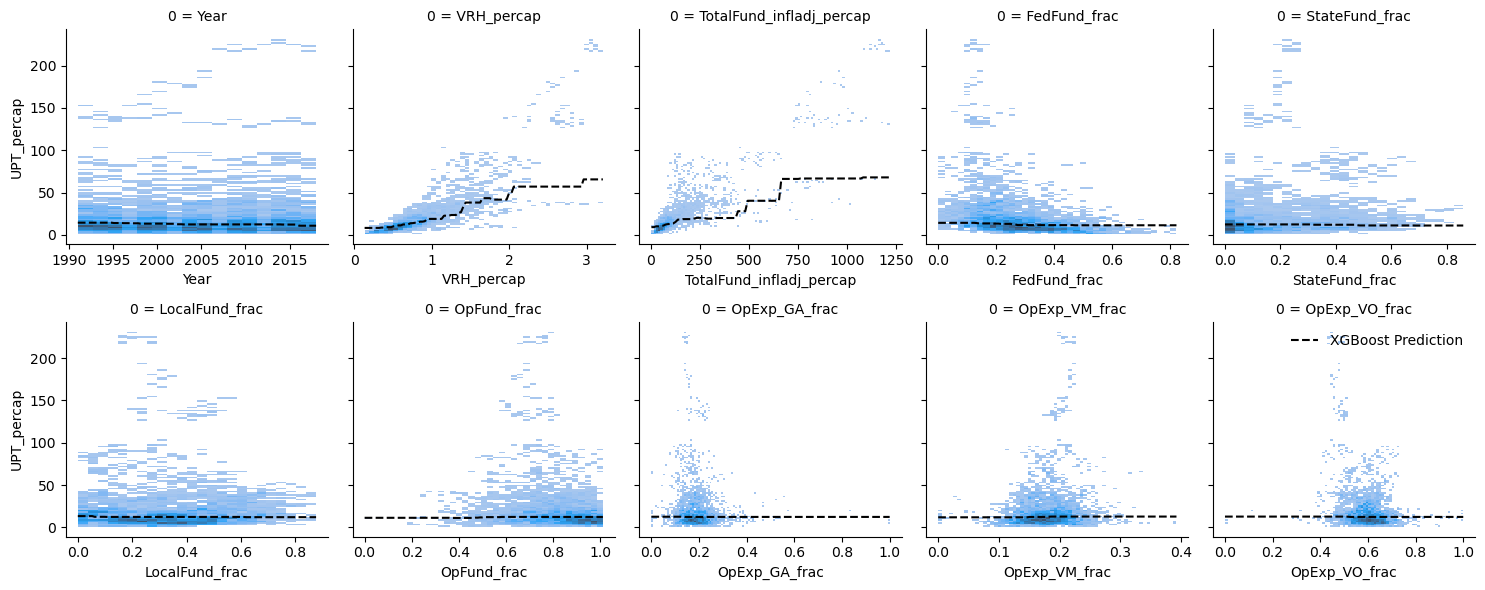

In [9]:
nrows = 100
x_base = pd.DataFrame(
    np.tile(train[select_features].median().values, (nrows, 1)),
    columns=select_features
)
g = sns.FacetGrid(pd.DataFrame(select_features), col=0, col_wrap=5, sharex=False)
for i, (ax, x_var) in enumerate(zip(g.axes, select_features)):
    sns.histplot(data=train, x=x_var, y=ycol, ax=ax)
    xmin = train[x_var].min()
    xmax = train[x_var].max()
    x_predict = x_base.copy()
    x_predict[x_var] = np.linspace(xmin, xmax, nrows)
    y_predict = xgb.predict(x_predict)
    ax.plot(x_predict[x_var], y_predict, 'k--', label='XGBoost Prediction')
    # ax.text(0.05, 0.85, f'm={mlr.coef_[i]:.02f}', transform=ax.transAxes)
g.tight_layout()
plt.legend(frameon=False)
plt.savefig(paths.plots / 'select_features.png', dpi=300)
plt.show()

## Test the model

Test on remaining 20% of cities with 1991-2018 data.

In [10]:
# Baseline
baseline_pred = train['UPT_percap'].mean() * np.ones(test.shape[0])
baseline_rmse = root_mean_squared_error(test['UPT_percap'], baseline_pred)

# Test MLR model
xgb_pred = xgb.predict(test[select_features])
xgb_rmse = root_mean_squared_error(test['UPT_percap'], xgb_pred)
print(baseline_rmse)
print(xgb_rmse)

21.20476823760112
9.232351347043988


Plot predicted vs test data

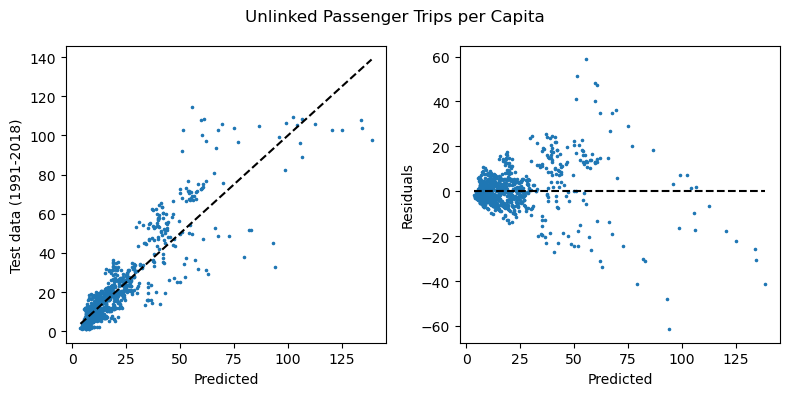

In [11]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8, 4), tight_layout=True)
axs[0].scatter(xgb_pred, test['UPT_percap'], marker='.', s=10)
bounds = [xgb_pred.min(), xgb_pred.max()]
axs[0].plot(bounds, bounds, 'k--')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Test data (1991-2018)')
# Plot residuals
axs[1].scatter(xgb_pred, test['UPT_percap'] - xgb_pred, marker='.', s=10)
axs[1].plot(bounds, [0, 0], 'k--')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Residuals')
fig.suptitle('Unlinked Passenger Trips per Capita')
plt.savefig(paths.plots / 'test_xgb_predict.png', dpi=300)
plt.show()

Plot predicted vs test data, scaled by city population.

In [12]:
# Import city population estimates
from parse_data import uza_population_estimates
years = np.arange(1991, 2020, 1)
city_pop = uza_population_estimates(years)[[str(y) for y in years]]
city_pop.columns = years # Make columns ints not strings
city_pop_stack = city_pop.stack()

# MultiIndex test dataframe
test_midx = test.reset_index().set_index(['UACE Code', 'Year'])

# Get population info for all test data
city_pop_stack.loc[test_midx.index]

UACE Code      
04222      1991    289588
           1992    294704
           1993    299820
           1994    304935
           1995    310051
                    ...  
20287      2014    327667
           2015    329567
           2016    331467
           2017    333366
           2018    335266
Length: 1008, dtype: int64

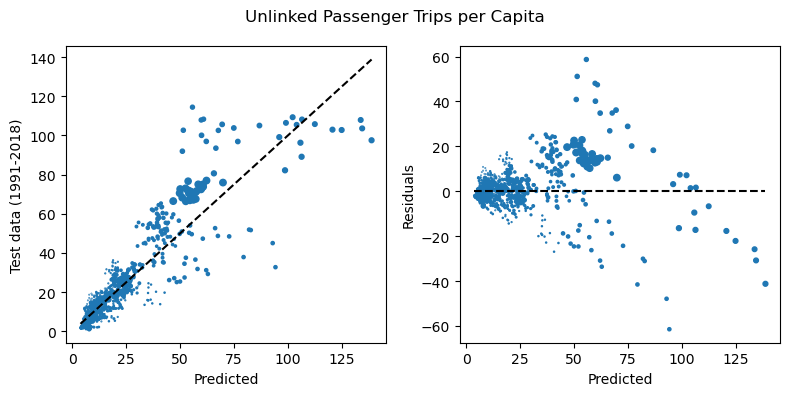

In [13]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8, 4), tight_layout=True)
marker_scale = 1e-5 * city_pop_stack.loc[test_midx.index]
axs[0].scatter(xgb_pred, test['UPT_percap'], marker='.', s=marker_scale)
bounds = [xgb_pred.min(), xgb_pred.max()]
axs[0].plot(bounds, bounds, 'k--')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Test data (1991-2018)')
# Plot residuals
axs[1].scatter(xgb_pred, test['UPT_percap'] - xgb_pred, marker='.', s=marker_scale)
axs[1].plot(bounds, [0, 0], 'k--')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Residuals')
fig.suptitle('Unlinked Passenger Trips per Capita')
# plt.savefig(paths.plots / 'test_xgb_predict.png', dpi=300)
plt.show()

The model does a poor job predicting a cluster of points with around 100 UPT per capita. These are all data from the DC area, which our model predicts should vary much more than it actually did.

In [14]:
test[test[ycol] > 90][ycol]

UACE Code
92242    114.398628
92242    108.268718
92242    107.846298
92242    102.537172
92242    102.614356
92242     93.470169
92242     91.910462
92242     96.918017
92242    100.033306
92242     96.865069
92242    103.768291
92242    105.614151
92242    105.010851
92242    105.409507
92242    108.147064
92242    106.386670
92242    105.742573
92242    107.855144
92242    109.260341
92242    103.552414
92242    102.738956
92242    102.918607
92242     99.101238
92242     97.494431
92242     96.249495
Name: UPT_percap, dtype: float64

In [15]:
city_info = pd.read_csv(paths.data / 'Cities.csv', index_col='UACE Code', dtype={'UACE Code': str})
city_info.loc['92242']

Primary UZA Name                     Washington--Arlington, DC--VA--MD
UZA Area SQ Miles                                              1294.51
UZA Population                                                 5174759
Cities               Washington DC, Rockville MD, Fairfax VA, Woodb...
Name: 92242, dtype: object

## Test on 2019 data

Test the model on 2019 data for all cities.

### Select the baseline

The below plot shows ridership for three hand-picked cities. While some cities have a strong trend with time, others do not. The best way to characterize most cities is a random walk, so we use a naive forecaset for our baseline model.

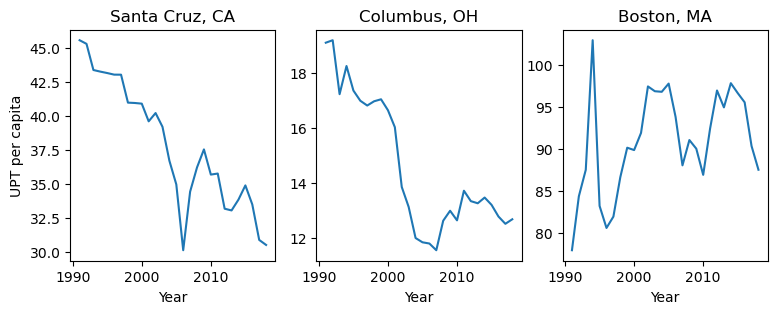

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True)

example_cities = ['Santa Cruz, CA', 'Columbus, OH', 'Boston, MA']

for i, city in enumerate(example_cities):
    code = city_info[city_info['Primary UZA Name'].str.contains(city)].index[0]
    axs[i].plot(train.loc[code]['Year'], train.loc[code][ycol])
    axs[i].set_xlabel('Year')
    axs[i].set_title(city)

axs[0].set_ylabel('UPT per capita')
plt.show()

In [17]:
test_2019 = consolidate_features(select_features[1:] + [ycol], dir='test')
test_2019

,Year,VRH_percap,TotalFund_infladj_percap,FedFund_frac,StateFund_frac,LocalFund_frac,OpFund_frac,OpExp_GA_frac,OpExp_VM_frac,OpExp_VO_frac,UPT_percap
UACE Code,,,,,,,,,,,
00766,2019,1.027761,119.304872,0.132993,0.009938,0.715167,0.947431,0.190074,0.186937,0.597039,12.070790
00901,2019,0.530555,56.313799,0.460471,0.027845,0.349635,0.894503,0.185938,0.265716,0.545108,8.899794
01171,2019,0.784314,166.685665,0.355761,0.000000,0.579064,0.694058,0.222501,0.183361,0.498701,13.446766
01495,2019,0.625402,74.256297,0.231034,0.600384,0.026360,0.807202,0.150709,0.116367,0.719658,7.560052
01792,2019,0.631442,142.368091,0.112257,0.787458,0.019165,0.478104,0.190948,0.190209,0.610883,7.570743
...,...,...,...,...,...,...,...,...,...,...,...
95833,2019,0.399526,54.628434,0.565412,0.102088,0.154550,0.619868,0.338026,0.141235,0.506929,4.999110
96670,2019,0.615793,52.596350,0.314354,0.185690,0.405273,0.858922,0.171415,0.152804,0.669476,6.452533
97291,2019,0.495052,65.700460,0.309040,0.399408,0.182147,0.826364,0.222540,0.170705,0.558774,6.619037


In [18]:
# Naive baseline
naive_pred = all_data[all_data['Year'] == 2018]['UPT_percap']
naive_rmse = root_mean_squared_error(test_2019['UPT_percap'], naive_pred)
print(naive_rmse)

xgb_pred_2019 = xgb.predict(test_2019[select_features])
xgb_rmse_2019 = root_mean_squared_error(test_2019['UPT_percap'], xgb_pred_2019)
print(xgb_rmse_2019)

0.9516874852900168
7.442117817829564


The naive baseline prediction does much better than the XGBoost model.

/var/folders/_s/lknhlnjn1g1cj388brpgztf80000gn/T/ipykernel_10131/551488214.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(paths.plots / 'test_xgb_predict_2019.png', dpi=300)
/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


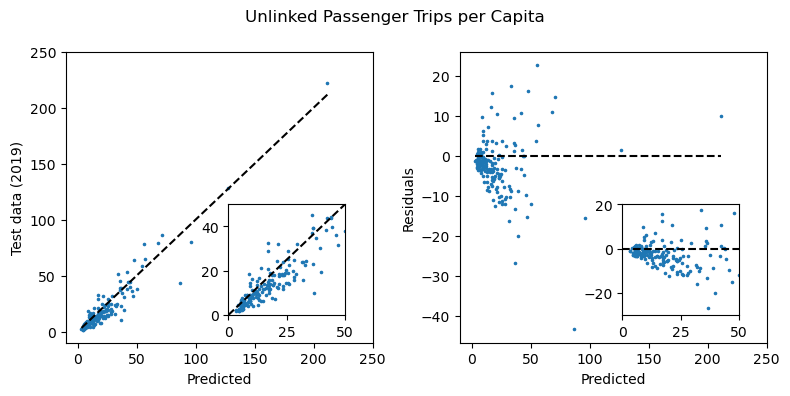

In [21]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8, 4), tight_layout=True)
axs[0].scatter(xgb_pred_2019, test_2019['UPT_percap'], marker='.', s=10)
bounds = [xgb_pred_2019.min(), xgb_pred_2019.max()]
axs[0].plot(bounds, bounds, 'k--')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Test data (2019)')
axs[0].set_xlim((-10, 250))
axs[0].set_ylim((-10, 250))
# Zoomed inset
ax0_ins = inset_axes(axs[0], width='38%', height='38%', loc='lower right', borderpad=2)
ax0_ins.scatter(xgb_pred_2019, test_2019['UPT_percap'], marker='.', s=10)
ax0_ins.plot([0, 50], [0, 50], 'k--')
ax0_ins.set_xlim((0, 50))
ax0_ins.set_ylim((0, 50))
# Plot residuals
axs[1].scatter(xgb_pred_2019, test_2019['UPT_percap'] - xgb_pred_2019, marker='.', s=10)
axs[1].plot(bounds, [0, 0], 'k--')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Residuals')
# Zoomed inset
ax1_ins = inset_axes(axs[1], width='38%', height='38%', loc='lower right', borderpad=2)
ax1_ins.scatter(xgb_pred_2019, test_2019['UPT_percap'] - xgb_pred_2019, marker='.', s=10)
ax1_ins.plot([0, 50], [0, 0], 'k--')
ax1_ins.set_xlim((0, 50))
ax1_ins.set_ylim((-30, 20))
fig.suptitle('Unlinked Passenger Trips per Capita')
plt.savefig(paths.plots / 'test_xgb_predict_2019.png', dpi=300)
plt.show()

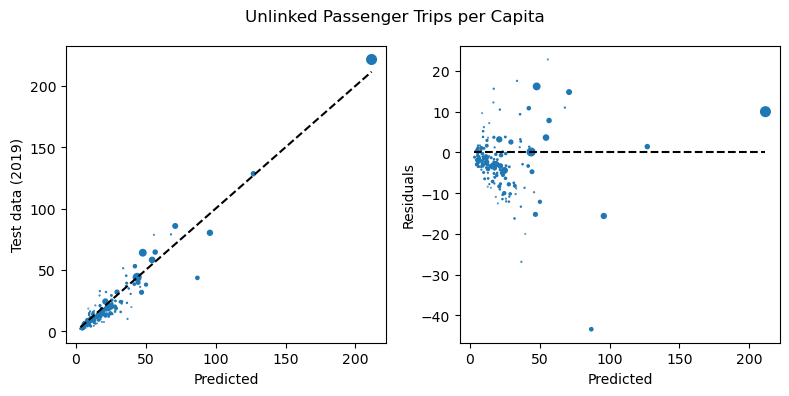

In [22]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8, 4), tight_layout=True)
test_2019_midx = test_2019.reset_index().set_index(['UACE Code', 'Year'])
marker_scale = 1e-5 * city_pop_stack.loc[test_2019_midx.index]
axs[0].scatter(xgb_pred_2019, test_2019['UPT_percap'], marker='.', s=marker_scale)
bounds = [xgb_pred_2019.min(), xgb_pred_2019.max()]
axs[0].plot(bounds, bounds, 'k--')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Test data (2019)')
# Plot residuals
axs[1].scatter(xgb_pred_2019, test_2019['UPT_percap'] - xgb_pred_2019, marker='.', s=marker_scale)
axs[1].plot(bounds, [0, 0], 'k--')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Residuals')
fig.suptitle('Unlinked Passenger Trips per Capita')
# plt.savefig(paths.plots / 'test_xgb_predict_2019.png', dpi=300)
plt.show()